# HW6 Reinforcement Learning

*   Author: Yuege Xie (EID:yx4256)
*   Python version: Python 3
*   CS 391L Machine Learning HW2

In [1]:
cd /content/drive/My Drive/2020-ml/reinforcement-learning

/content/drive/My Drive/2020-ml/reinforcement-learning


In [2]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1023)
# check the python version
from platform import python_version
print("Current python version is {}".format(python_version()))
%matplotlib inline

Current python version is 3.6.9


In [0]:
class QTable:
    def __init__(self, env, lr=0.9, eps=0.1, gamma=0.9):
        self.env = env
        self.states = env.states
        self.actions = env.actions
        self.lr = lr
        self.eps = eps
        self.gamma = gamma
        self.qtable = {}
        # initiaize q table
        for s in self.states:
            self.qtable[s] = {}
            for a in self.actions:    
                self.qtable[s][a] = 0.0
    
    def get_action(self, state):
        if np.random.uniform() > self.eps:
            action = max(self.actions, key=lambda k: self.qtable[state][k])
        else:
            idx =  np.random.choice(len(self.actions))
            action = self.actions[idx]
        return action

    def update(self, state, training=False):
        action = self.get_action(state)
        next_state, reward = self.env.step(state, action)
        if training:
            if self.env.cur_pos[0] != self.env.col-1:
                q_next = reward + self.gamma * max(self.qtable[next_state].values())
            else:
                q_next = reward
            q_now = self.qtable[state][action]
            self.qtable[state][action] += self.lr * (q_next - q_now)
        return next_state

In [0]:
def plot_results(env, title):
    
    # plot grid
    fig = plt.figure(figsize=(18,6))
    ax = fig.add_subplot(1, 1, 1)
    plt.xlim(-.5, env.col-0.5)
    plt.ylim(-.5, env.row-0.5)
    y_minor_ticks = np.arange(0, env.row, 1)
    x_minor_ticks = np.arange(0, env.col, 1)
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_minor_ticks, minor=True)  
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(which='both')

    if env.obs:
        for ob in env.obs:
            plt.plot(ob[0], ob[1], 's', color='r', markersize=12)

    if env.litter:
        for li in env.litter:
            plt.plot(li[0], li[1], '*', color='g', markersize=18)
            
    # plot initial and end points
    plt.plot(env.trace['init'][0], env.trace['init'][1] , 
             'D', color='b', markersize=12)
    env.end = env.trace['pos'][-1]
    plt.plot(env.end[0], env.end[1], 'D', color='b', markersize=12)

    # plot trace
    last = env.trace['init']
    for i in range(len(env.trace['pos'])):
        x, y = env.trace['pos'][i][0], env.trace['pos'][i][1]
        plt.scatter(x, y, color='orange', s=200, alpha=0.3)
        if env.trace['pos'][i] != last:
            dx, dy = env.trace['act'][i][0], env.trace['act'][i][1]
            plt.arrow(last[0], last[1], dx, dy, 
                  head_width=0.2, head_length=0.2, fc='k', ec='k')
        last = env.trace['pos'][i]
    plt.title(f"Simulation of Agent: {title}")
    plt.savefig(f"./plots/{title}.pdf")
    plt.show()  

In [0]:
def train(env_class, episodes, max_iter=500):
    env = env_class(col=25, row=6, seed=1023)
    qt = QTable(env)
    
    for ep in range(episodes):
        print(ep, end=' ')
        env = env_class(col=25, row=6, seed=23+np.random.randint(100))
        qt.env = env
        next_state = qt.env.init
        i = 0
        while qt.env.cur_pos[0] != qt.env.col-1 and i<max_iter:
            next_state = qt.update(next_state, training=True)
            i=i+1

        if (ep+1)%1000 ==0:
                print("\n")
    return qt

In [0]:
def simulate(qt, env_class, seed, max_iter=1e3):
    qt.eps = -1
    qt.env = env_class(col=25, row=6, seed=seed)

    next_state = qt.env.init
    i = 0
    while qt.env.cur_pos[0] != qt.env.col-1 and i<max_iter:
        next_state = qt.update(next_state, training=False)
        i=i+1
    return qt.env

## "Forth" Module

In [0]:
def check_step(state, col, row):
    state[0] = max(0, state[0])
    state[0] = min(col-1, state[0])
    state[1] = max(0, state[1])
    state[1] = min(row-1, state[1])
    return tuple([state[0], state[1]])

class EnvForth:
    def __init__(self, col , row, seed):
        self.col = col
        self.row = row
        self.states = [(a,b) for a in range(col) for b in range(row)]
        self.actions = [(0,1), (0,-1), (-1,0), (1,0)]
        self.obs, self.litter = None, None
        
        np.random.seed(seed)
        self.init = (0, np.random.choice(row))
        self.trace = {'init': self.init,'act':[], 'pos':[]}
        self.cur_pos = self.init

    def step(self, state, action): 
        next_state = [state[0]+action[0], state[1]+action[1]]
        next_state = check_step(next_state, self.col, self.row)
        reward_val = self.reward(state, action, next_state)
        self.trace['act'].append(action)
        self.trace['pos'].append(next_state)
        self.cur_pos = next_state
        return next_state, reward_val

    def reward(self, state, action, next_state):
        # reach the goal
        if next_state[0] == self.col-1:
            return 100
        elif next_state[0] > state[0]: 
            return 5
        elif next_state[0] < state[0]: 
            return -5
        else:
            return 0

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

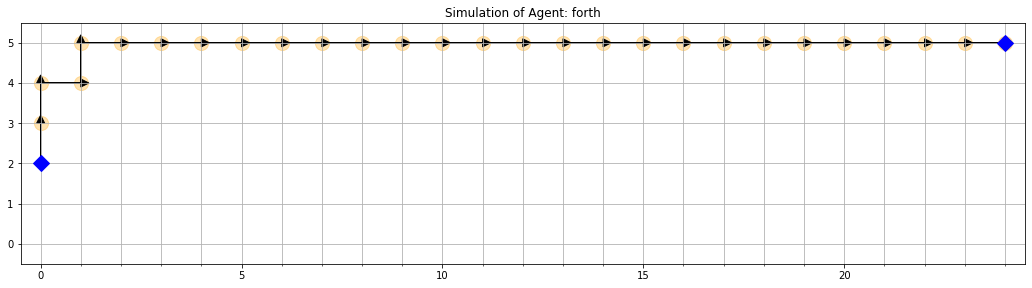

In [336]:
env_forth = EnvForth
qt_forth = train(env_forth, episodes=500)
sample = simulate(qt_forth, env_forth, seed=888)
plot_results(sample, "forth")

## "Stay on the Path" Module

In [0]:
class EnvStay(EnvForth):
    def __init__(self, col , row, seed):
        super().__init__(col , row, seed)
    def reward(self, state, action, next_state):
        # reach the goal
        if next_state[0] == self.col-1:
            return 100
        elif next_state[0] > state[0]: 
            return 5
        elif next_state[0] < state[0]: 
            return -5
        elif next_state == state:
            return -50
        else:
            return 0 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

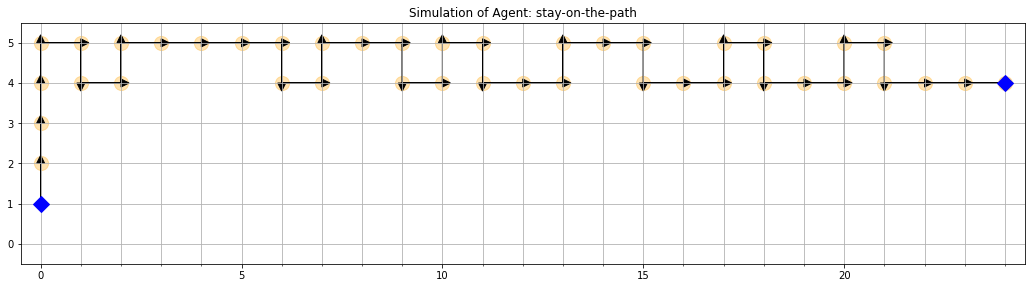

In [338]:
env_stay = EnvStay
qt_stay = train(env_stay, episodes=100)
sample = simulate(qt_stay, env_stay, 10)
plot_results(sample, "stay-on-the-path")

## "Obstacles" Module

In [0]:
class EnvObstacles:
    def __init__(self, col , row, seed):
        self.col = col
        self.row = row
        tmp = [0,1]
        self.states = [(a,b,c,d) for a in tmp for b in tmp 
                       for c in tmp for d in tmp]
        self.actions = [(0,1), (0,-1), (-1,0), (1,0)] # up, down, left, right
        
        np.random.seed(seed)
        self.init_pos = (0, np.random.choice(row))
        self.trace = {'init': self.init_pos, 'act':[], 'pos':[]}
        self.litter = None

        # set obstacles
        num = self.col * self.row // 5
        x = np.random.randint(0, self.col, num)
        y = np.random.randint(0, self.row, num)
        self.obs = set([(x[i], y[i]) for i in range(len(x))])
        if self.init_pos in self.obs:
            self.obs.remove(self.init_pos)
        # record current true state
        self.init = self.pos_to_state(self.init_pos)
        self.cur_pos = self.init_pos
    
    def pos_to_state(self, pos):
        abs_list = []
        for act in self.actions:
            if tuple(p+q for p, q in zip(act, pos)) in self.obs:
                abs_list.append(1)
            else:
                abs_list.append(0)
        state = tuple(abs_list)
        return state

    def step(self, state, action):
        next_pos = [self.cur_pos[0]+action[0], self.cur_pos[1]+action[1]]
        next_pos = check_step(next_pos, self.col, self.row)
        reward_val = self.reward(next_pos)
        next_state = self.pos_to_state(next_pos)
        # record action and position
        self.trace['act'].append(action)
        self.trace['pos'].append(next_pos)
        # change current position
        self.cur_pos = next_pos

        return next_state, reward_val

    def reward(self, next_pos):
        if next_pos in self.obs:
            return -30
        elif next_pos[0] == self.col-1: 
            return 100
        elif next_pos[0] > self.cur_pos[0]: 
            return 5
        elif next_pos[0] < self.cur_pos[0]: 
            return -5
        elif next_pos == self.cur_pos:
            return -20     
        else:
            return 0 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

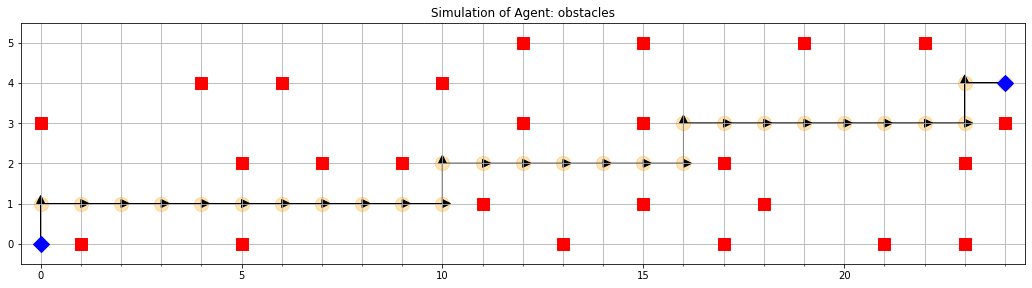

In [340]:
env_obs = EnvObstacles
qt_obs = train(env_obs, 2000)
sample = simulate(qt_obs, env_obs, 15)
plot_results(sample, "obstacles")

## "Litter" Module

In [0]:
class EnvLitter:
    def __init__(self, col , row, seed):
        self.col = col
        self.row = row
        tmp = [0,1]
        self.states = [(a,b,c,d) for a in tmp for b in tmp 
                       for c in tmp for d in tmp]
        self.actions = [(0,1), (0,-1), (-1,0), (1,0)] # up, down, left, right
        
        np.random.seed(seed)
        self.init_pos = (0, np.random.choice(row))
        self.trace = {'init': self.init_pos, 'act':[], 'pos':[]}
        self.obs = None

        # set obstacles
        num = self.col * self.row // 5
        x = np.random.randint(0, self.col, num)
        y = np.random.randint(0, self.row, num)
        self.litter = set([(x[i], y[i]) for i in range(len(x))])
        self.cur_litter = set([(x[i], y[i]) for i in range(len(x))])
        if self.init_pos in self.litter:
            self.litter.remove(self.init_pos)
            self.cur_litter.remove(self.init_pos)
        # record current true state
        self.init = self.pos_to_state(self.init_pos)
        self.cur_pos = self.init_pos
        
    
    def pos_to_state(self, pos):
        abs_list = []
        for act in self.actions:
            if tuple(p+q for p, q in zip(act, pos)) in self.cur_litter:
                abs_list.append(1)
            else:
                abs_list.append(0)
        state = tuple(abs_list)
        return state

    def step(self, state, action):
        next_pos = [self.cur_pos[0]+action[0], self.cur_pos[1]+action[1]]
        next_pos = check_step(next_pos, self.col, self.row)
        reward_val = self.reward(next_pos)
        next_state = self.pos_to_state(next_pos)
        # record action and position
        self.trace['act'].append(action)
        self.trace['pos'].append(next_pos)
        # change current position
        self.cur_pos = next_pos
        return next_state, reward_val

    def reward(self, next_pos):
        re = -3
        if next_pos[0] == self.col-1: 
            return 100
        if next_pos in self.cur_litter:
            self.cur_litter.remove(next_pos)
            re += 13
        if next_pos[0] > self.cur_pos[0]:
            re += 1
        if next_pos == self.cur_pos:
            re -= 10
        return re

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

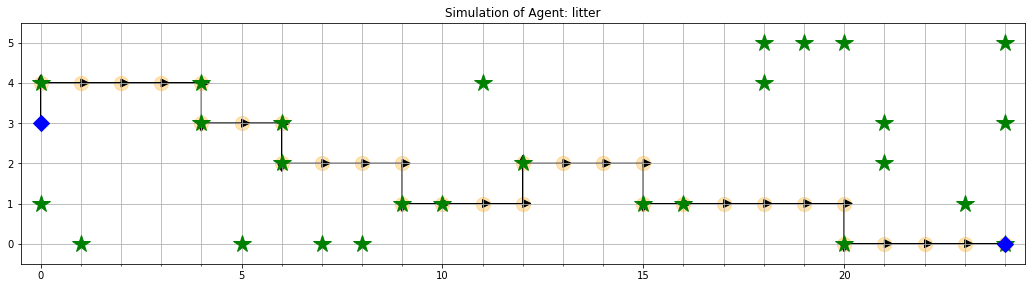

In [342]:
env_litter = EnvLitter
qt_litter = train(env_litter, 5000)
sample = simulate(qt_litter, env_litter, seed=1023)
plot_results(sample, "litter")

## Final Module

In [0]:
class EnvGlobal:
    def __init__(self, col , row, seed):
        self.col = col
        self.row = row
        tmp = [-1,0,1]
        self.states = [(a,b,c,d) for a in tmp for b in tmp 
                       for c in tmp for d in tmp]
        self.actions = [(0,1), (0,-1), (-1,0), (1,0)] # up, down, left, right
        
        np.random.seed(seed)
        self.init_pos = (0, np.random.choice(row))
        self.trace = {'init': self.init_pos, 'act':[], 'pos':[]}

        # set obstacles
        num = self.col * self.row // 5
        x = np.random.randint(0, self.col, num)
        y = np.random.randint(0, self.row, num)
        self.litter = set([(x[i], y[i]) for i in range(len(x))])
        self.cur_litter = set([(x[i], y[i]) for i in range(len(x))])

        xx = np.random.randint(0, self.col, num)
        yy = np.random.randint(0, self.row, num)
        self.obs = set([(xx[i], yy[i]) for i in range(len(xx))])
        self.obs = self.obs - self.litter
        
        if self.init_pos in self.litter:
            self.litter.remove(self.init_pos)
            self.cur_litter.remove(self.init_pos)
        elif self.init_pos in self.obs:
            self.obs.remove(self.init_pos)

        # record current true state
        self.init = self.pos_to_state(self.init_pos)
        self.cur_pos = self.init_pos
        
    
    def pos_to_state(self, pos):
        abs_list = []
        for act in self.actions:
            tmp = tuple(p+q for p, q in zip(act, pos)) 
            if tmp in self.cur_litter:
                abs_list.append(1)
            elif tmp in self.obs:
                abs_list.append(-1)
            else:
                abs_list.append(0)
        state = tuple(abs_list)
        return state

    def step(self, state, action):
        next_pos = [self.cur_pos[0]+action[0], self.cur_pos[1]+action[1]]
        next_pos = check_step(next_pos, self.col, self.row)
        reward_val = self.reward(next_pos)
        next_state = self.pos_to_state(next_pos)
        # record action and position
        self.trace['act'].append(action)
        self.trace['pos'].append(next_pos)
        # change current position
        self.cur_pos = next_pos
        return next_state, reward_val

    def reward(self, next_pos):
        re = -3
        if next_pos[0] == self.col-1: 
            return 100
        if next_pos in self.cur_litter:
            self.cur_litter.remove(next_pos)
            re += 20
        elif next_pos in self.obs:
            re -= 10
        if next_pos[0] > self.cur_pos[0]:
            re += 2
        if next_pos == self.cur_pos:
            re -= 20
        return re

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

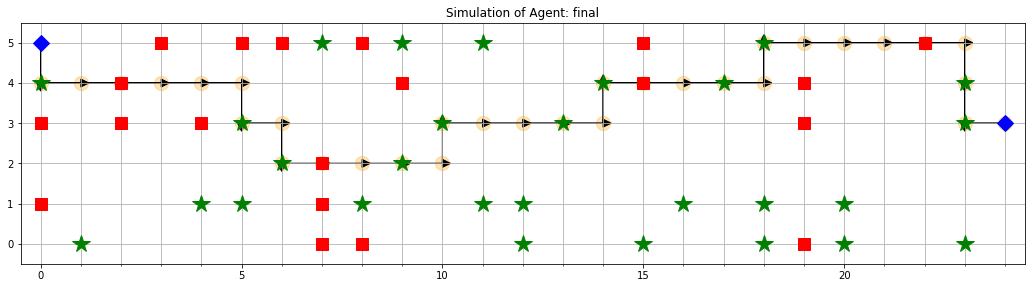

In [363]:
env = EnvGlobal
qt = train(env, 5000)
sample = simulate(qt, env, seed=1)
plot_results(sample, "final")